In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

['/home/jovyan/Landslide_EarlyDetection/examples/weather',
 '/opt/conda/lib/python37.zip',
 '/opt/conda/lib/python3.7',
 '/opt/conda/lib/python3.7/lib-dynload',
 '',
 '/opt/conda/lib/python3.7/site-packages',
 '/opt/conda/lib/python3.7/site-packages/descarteslabs_viewer-0.0.1-py3.7.egg',
 '/opt/conda/lib/python3.7/site-packages/ipython_genutils-0.2.0-py3.7.egg',
 '/opt/conda/lib/python3.7/site-packages/IPython/extensions',
 '/home/jovyan/.ipython',
 '../../']

In [4]:
from pprint import pprint
import numpy as np
import descarteslabs as dl

from src.ReMasFrame import ReMasFrame

In [5]:
# buffer_size
BS = 0.1

nasa_df = ReMasFrame()

# Choose an idx --> a landslide (or filter the geodataframe :D)
idx_test = 11031

# changes Point to Polygon
# nasa_df_polygon = nasa_df.create_box(8000000)

# Returns products that we use as a dict
products = nasa_df.get_products()

nasa_df.loc[idx_test, :]

/opt/conda/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


location_description        Ayu, Ozgon, Osh, Kyrgyzstan
landslide_size                                    large
event_date                                   2017-04-29
landslide_category                  translational_slide
landslide_trigger                              downpour
fatality_count                                       24
injury_count                                        NaN
longitude                                       73.4724
latitude                                        40.8864
geometry                POINT (73.47237853 40.88639497)
Name: 11031, dtype: object

## Obtención del producto

In [6]:
# Lista de categorias
products.keys()

dict_keys(['weather', 'soil_moist', 'elevation', 'population'])

In [7]:
# Elegir una categoria
cat = products["weather"]
# Mostrar productos
cat.keys()

dict_keys(['goes', 'gsod', 'chirps', 'cfs'])

In [8]:
# Elegir producto
prod = cat["gsod"]
prod

{'name': 'GSOD Daily Interpolation Weather Product',
 'id': 'daily-weather:gsod-interpolated:v0',
 'res': '10km',
 'bands': ['tavg', 'tmax', 'tmin', 'rh', 'prec'],
 'descrip': 'interpolated raster from 1980-01-01 for geographical area from -180 deg to 180 deg longitude, and from -60 to 60 deg latitude.'}

In [9]:
def get_scenes(product, res, buffer_size=BS):
    # Returns start and end date of a 4 day interval
    start_date, end_date = nasa_df.date_interval(nasa_df.event_date[idx_test], delta=10)
    
    scenes, ctx = ReMasFrame.search_scenes(
        nasa_df['geometry'][idx_test].buffer(buffer_size).envelope, 
        product['id'], 
        start_date=start_date, 
        end_date=end_date, 
        limit=20
    )
    
    new_ctx = ctx.assign(resolution=res)
    
    return scenes, new_ctx, start_date, end_date

def get_composite(product, res, buffer_size=BS, bands=None):
    
    scenes, new_ctx, _, _ = get_scenes(product, buffer_size, res)
    
    bands = product["bands"] if bands is None else bands
    
    if not scenes:
        raise IndexError("El conjunto de escenas está vacía.")
        
    arr_stack = scenes.stack(bands, new_ctx)
    composite = np.ma.median(arr_stack, axis=0)
        
    
    return (scenes, new_ctx), composite


In [10]:
# Mostrar las bandas
prod["bands"], len(prod["bands"])

(['tavg', 'tmax', 'tmin', 'rh', 'prec'], 5)

In [17]:
scenes, ctx, ini, end = get_scenes(
    prod, 
    buffer_size=BS, #  10kmx10km
    res=0.1         # 0.2 deg x pix approx 20km x pix which is resolution of the sensor
)

scenes, ctx

(SceneCollection of 20 scenes
   * Dates: Apr 19, 2017 to May 08, 2017
   * Products: daily-weather:gsod-interpolated:v0: 20,
 AOI(geometry=<shapely.geom...x7fb37420b9d0>,
     resolution=0.1,
     crs='+proj=latlon...GS84 +no_defs',
     align_pixels=True,
     bounds=(73.37237853, 40.786394969999996, 73.57237853, 40.98639497),
     bounds_crs='EPSG:4326',
     shape=None))

In [18]:
scene_stack = scenes.stack(prod['bands'], ctx)
scene_stack.shape

(20, 5, 3, 3)

La tupla significa (cantidad de imagenes, las bandas, tamaño de la imagen, tamaño de la imagen)

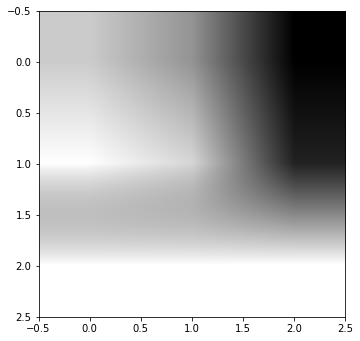

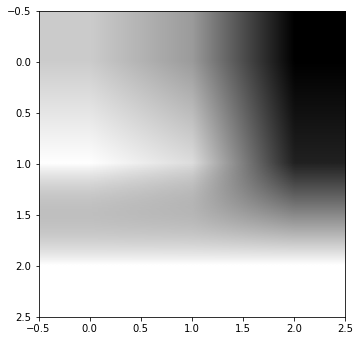

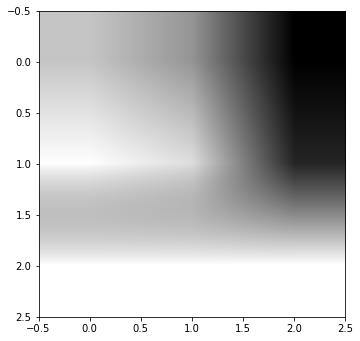

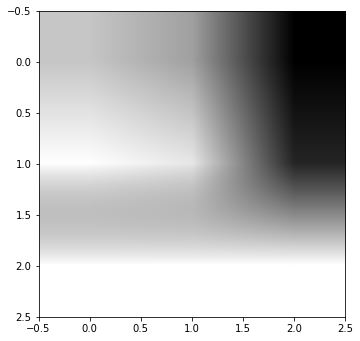

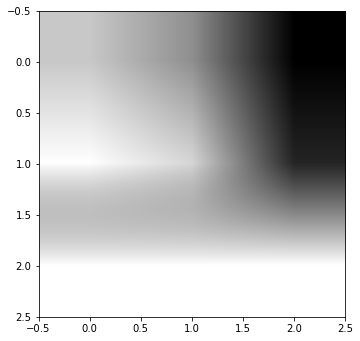

In [20]:
for scene in scenes[0:5]:
    arr = scene.ndarray(bands=prod["bands"][0],
                        ctx=ctx)
    
    dl.scenes.display(arr, size=5)